# Automated Machine Learning with Azure ML service
_**Energy Demand Forecasting**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)

<img src="https://cdn.thenewstack.io/media/2018/10/2e4f0988-az-ml-0.png">

> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-auto-train-forecast 

## Introduction
In this example, we show how AutoML can be used for energy demand forecasting.

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook you would see
1. Creating an Experiment in an existing Workspace
2. Instantiating AutoMLConfig with new task type "forecasting" for timeseries data training, and other timeseries related settings: for this dataset we use the basic one: "time_column_name" 
3. Training the Model using local compute
4. Exploring the results
5. Viewing the engineered names for featurized data and featurization summary for all raw features
6. Testing the fitted model

## Setup


In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.0.48


In [14]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 18:50:55) [MSC v.1915 64 bit (AMD64)]'

As part of the setup you have already created a <b>Workspace</b>. For AutoML you would need to create an <b>Experiment</b>. An <b>Experiment</b> is a named object in a <b>Workspace</b>, which is used to run experiments.

In [5]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl_forecast-energy'
# project folder
project_folder = './sample_projects/automl-local-energydemandforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.48
Workspace,azuremlservice
Resource Group,azuremlserviceresourcegroup
Location,westeurope
Project Directory,./sample_projects/automl-local-energydemandforecasting
Run History Name,automl_forecast-energy


## Data
Read energy demanding data from file, and preview data.

In [6]:
data = pd.read_csv("nyc_energy.csv", parse_dates=['timeStamp'])
data.head(10)

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61
5,2012-01-01 05:00:00,4274.70,0.00,39.02
6,2012-01-01 06:00:00,4324.90,0.00,38.78
7,2012-01-01 07:00:00,4350.00,0.00,42.74
8,2012-01-01 08:00:00,4480.90,0.00,38.90
9,2012-01-01 09:00:00,4664.20,0.00,44.67


In [7]:
data.describe()

,demand,precip,temp
count,49124.00,48975.00,49019.00
mean,6067.45,0.00,55.52
std,1285.61,0.02,17.70
min,2859.60,0.00,0.33
25%,5133.86,0.00,41.41
50%,6020.07,0.00,56.26
75%,6684.30,0.00,70.54
max,11456.00,0.91,97.26


In [8]:
# let's take note of what columns means what in the data
time_column_name = 'timeStamp'
target_column_name = 'demand'

### Split the data into train and test sets


In [9]:
X_train = data[data[time_column_name] < '2017-02-01']
X_test = data[data[time_column_name] >= '2017-02-01']
y_train = X_train.pop(target_column_name).values
y_test = X_test.pop(target_column_name).values

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44591 entries, 0 to 49147
Data columns (total 3 columns):
timeStamp    44591 non-null datetime64[ns]
precip       44384 non-null float64
temp         44428 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.4 MB


In [11]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4614 entries, 44567 to 49204
Data columns (total 3 columns):
timeStamp    4614 non-null datetime64[ns]
precip       4591 non-null float64
temp         4591 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 144.2 KB


## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iterations**|Number of iterations. In each iteration, Auto ML trains a specific pipeline on the given data|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], targets values.|
|**n_cross_validations**|Number of cross validation splits.|
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. 

In [12]:
automl_settings = {
    "time_column_name": time_column_name    
}


automl_config = AutoMLConfig(task = 'forecasting',
                             debug_log = 'automl_nyc_energy_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations = 10,
                             iteration_timeout_minutes = 5,
                             X = X_train,
                             y = y_train,
                             n_cross_validations = 3,
                             path=project_folder,
                             verbosity = logging.INFO,
                            **automl_settings)

Submitting the configuration will start a new run in this experiment. For local runs, the execution is synchronous. Depending on the data and number of iterations, this can run for a while. Parameters controlling concurrency may speed up the process, depending on your hardware.

You will see the currently running iterations printing to the console.

In [13]:
%%time
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_6dbbd205-3674-4b93-8e43-ba33766477c4
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:16       0.0768  

In [8]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl_forecast-energy,AutoML_04016794-9f5b-47a0-aa4b-5ba33e694cb0,automl,Running,Link to Azure Portal,Link to Documentation


### Retrieve the Best Model
Below we select the best pipeline from our iterations. The get_output method on automl_classifier returns the best run and the fitted model for the last fit invocation. There are overloads on get_output that allow you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [16]:
best_run, fitted_model = local_run.get_output()
fitted_model.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None)),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('3', Pipeline(memory=None,
       steps=[('standardscalerwrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x00000206580B4D68>), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='log2...ators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0, warm_start=False))]))],
                 flatten_transform=None,
                 weights=[0.3333333333333333, 0.4444444444444444, 0.2222222222222222]))]

### View the engineered names for featurized data
Below we display the engineered feature names generated for the featurized data using the time-series featurization.

In [17]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['precip',
 'temp',
 'precip_WASNULL',
 'temp_WASNULL',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

### Test the Best Fitted Model

For forecasting, we will use the `forecast` function instead of the `predict` function. There are two reasons for this.

We need to pass the recent values of the target variable `y`, whereas the scikit-compatible `predict` function only takes the non-target variables `X`. In our case, the test data immediately follows the training data, and we fill the `y` variable with `NaN`. The `NaN` serves as a question mark for the forecaster to fill with the actuals. Using the forecast function will produce forecasts using the shortest possible forecast horizon. The last time at which a definite (non-NaN) value is seen is the _forecast origin_ - the last time when the value of the target is known. 

Using the `predict` method would result in getting predictions for EVERY horizon the forecaster can predict at. This is useful when training and evaluating the performance of the forecaster at various horizons, but the level of detail is excessive for normal use.

In [18]:
# Replace ALL values in y_pred by NaN. 
# The forecast origin will be at the beginning of the first forecast period
# (which is the same time as the end of the last training period).
y_query = y_test.copy().astype(np.float)
y_query.fill(np.nan)
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_fcst, X_trans = fitted_model.forecast(X_test, y_query)

In [19]:
# limit the evaluation to data where y_test has actuals
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name = 'predicted'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)

df_all = align_outputs(y_fcst, X_trans, X_test, y_test)
df_all.head()

,timeStamp,_automl_dummy_grain_col,predicted,precip,temp,demand
0,2017-02-01 00:00:00,_automl_dummy_grain_col,4970.18,0.00,31.45,5090.62
1,2017-02-01 01:00:00,_automl_dummy_grain_col,4819.92,0.00,32.44,4839.25
2,2017-02-01 02:00:00,_automl_dummy_grain_col,4756.52,0.00,33.19,4702.52
3,2017-02-01 03:00:00,_automl_dummy_grain_col,4747.67,0.00,33.61,4629.94
4,2017-02-01 04:00:00,_automl_dummy_grain_col,4797.94,0.00,32.30,4653.38


Looking at `X_trans` is also useful to see what featurization happened to the data.

In [20]:
X_trans

,,precip,temp,precip_WASNULL,temp_WASNULL,year,half,quarter,month,day,hour,am_pm,hour12,wday,qday,week,_automl_target_col
timeStamp,_automl_dummy_grain_col,,,,,,,,,,,,,,,,
2017-02-01 00:00:00,_automl_dummy_grain_col,0.00,31.45,0.00,0.00,2017,1,1,2,1,0,0,0,2,32,5,4970.18
2017-02-01 01:00:00,_automl_dummy_grain_col,0.00,32.44,0.00,0.00,2017,1,1,2,1,1,0,1,2,32,5,4819.92
2017-02-01 02:00:00,_automl_dummy_grain_col,0.00,33.19,0.00,0.00,2017,1,1,2,1,2,0,2,2,32,5,4756.52
2017-02-01 03:00:00,_automl_dummy_grain_col,0.00,33.61,0.00,0.00,2017,1,1,2,1,3,0,3,2,32,5,4747.67
2017-02-01 04:00:00,_automl_dummy_grain_col,0.00,32.30,0.00,0.00,2017,1,1,2,1,4,0,4,2,32,5,4797.94
2017-02-01 05:00:00,_automl_dummy_grain_col,0.00,33.34,0.00,0.00,2017,1,1,2,1,5,0,5,2,32,5,4803.54
2017-02-01 06:00:00,_automl_dummy_grain_col,0.00,35.93,0.00,0.00,2017,1,1,2,1,6,0,6,2,32,5,5120.68
2017-02-01 07:00:00,_automl_dummy_grain_col,0.00,37.36,0.00,0.00,2017,1,1,2,1,7,0,7,2,32,5,5789.01
2017-02-01 08:00:00,_automl_dummy_grain_col,0.00,38.20,0.00,0.00,2017,1,1,2,1,8,0,8,2,32,5,5975.96


### Calculate accuracy metrics


In [21]:
def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    APE = 100*np.abs((actual_safe - pred_safe)/actual_safe)
    return np.mean(APE)

Simple forecasting model
[Test Data] 
Root Mean squared error: 482.77
mean_absolute_error score: 376.80
MAPE: 6.35


<IPython.core.display.Javascript object>


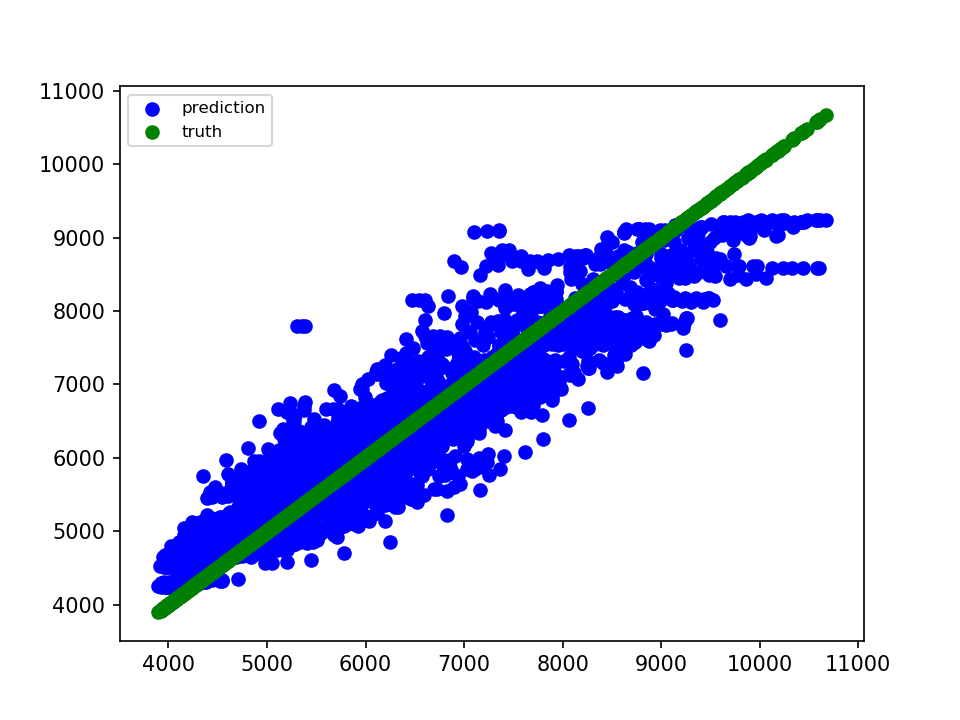

In [22]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
%matplotlib notebook
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()